#CS 457 - Homework Assignment 12: Time Series Analysis

#Name: Muhammad
##Id: 06369

In [3]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore") #optional
plt.style.use('fivethirtyeight') #optional
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [4]:
df = pd.read_csv('karachi-weather-2021-2023.csv', parse_dates= ['datetime'])
df = df.set_index('datetime')
df.head()

,temp
datetime,
2021-01-01,15.0
2021-01-02,15.4
2021-01-03,15.6
2021-01-04,16.3
2021-01-05,17.1


#Q1)

In [5]:
week_data = df['temp'].resample('W').mean()
week_data.head()

datetime
2021-01-03    15.333333
2021-01-10    16.028571
2021-01-17    17.085714
2021-01-24    19.457143
2021-01-31    17.800000
Freq: W-SUN, Name: temp, dtype: float64

#Q2)

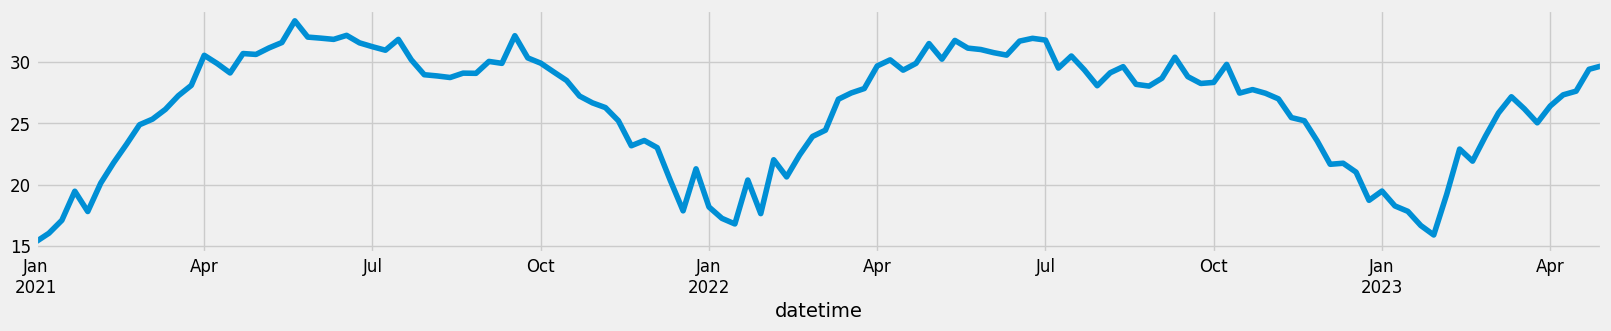

In [6]:
week_data.plot(figsize=(18, 3))
plt.show()

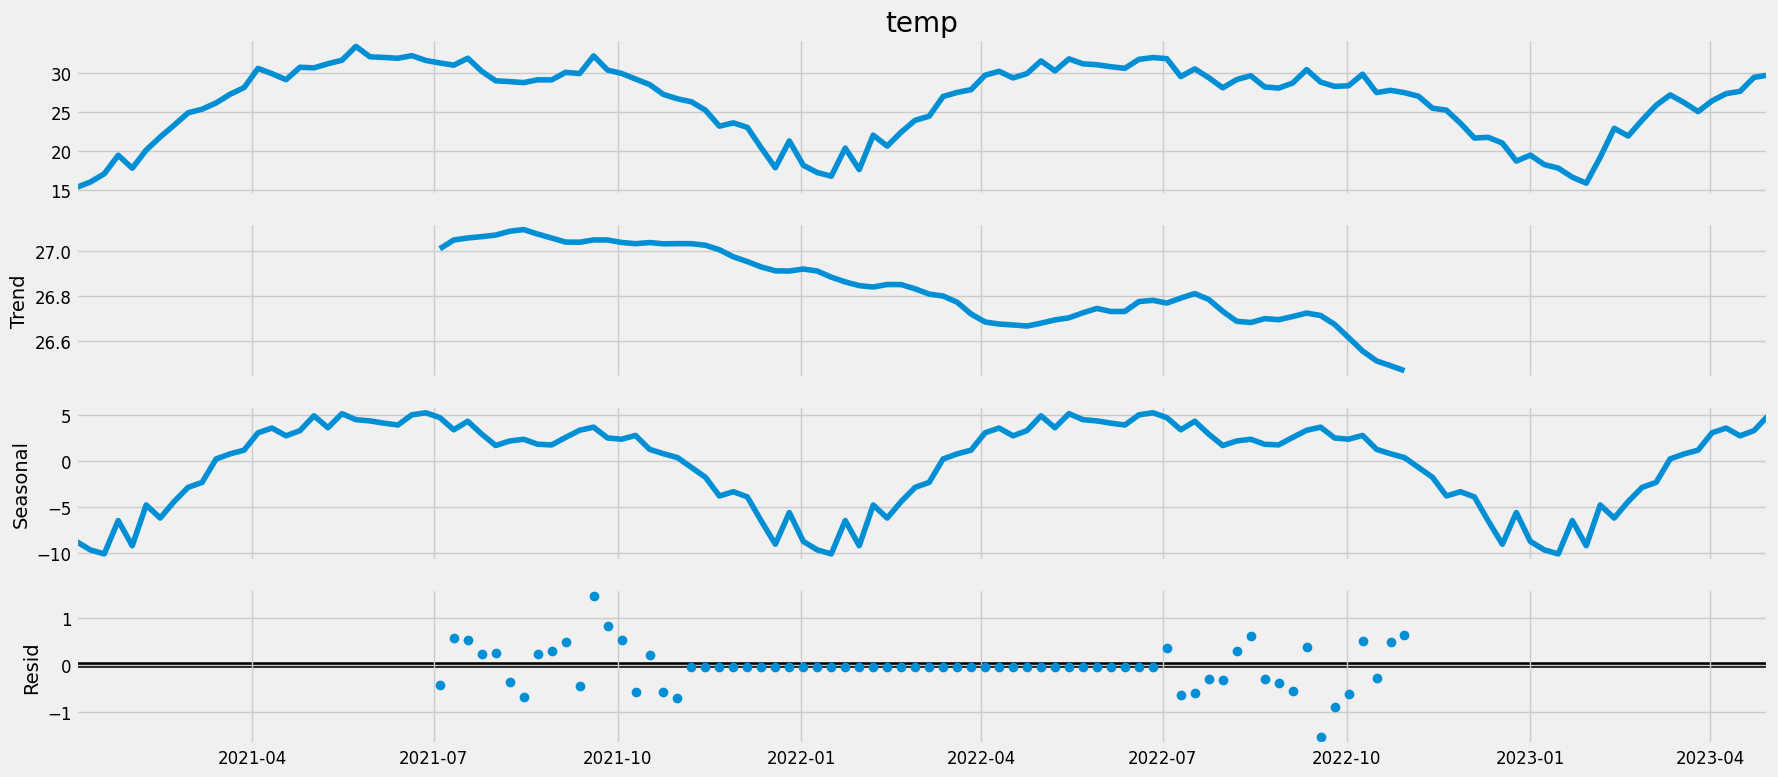

In [7]:
decomposition = sm.tsa.seasonal_decompose(week_data, model='additive')
rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()

##Analysis

If a dataset shows an increasing or decreasing pattern in the data, it is indicated by its trend component. Although there are a few spots where the temperature appears to be rising, overall the dataset shows a clear decreasing trend in the plot that is provided. Global warming, which is caused by modifications in atmospheric patterns that result in generally lower temperatures, could be blamed for this temperature decrease. Conversely, any pattern that consistently repeats over time is referred to as the dataset's seasonality component. The seasonal graph above illustrates a number of patterns that occur throughout the year, with each year's first half seeing an increase in temperature and the second half seeing a decrease. Given that Karachi has hot summers and chilly winters, this trend makes sense. Lastly, the part of the data that cannot be explained by seasonal patterns and trends is represented by the residuals component. Seasonal patterns and trends during specific times allow us to see changes in the temperature data. These differences might arise from errors or unexpected weather-related outliers, or they might be the result of the model's incapacity to fully represent all the patterns in the data.

#Q3)

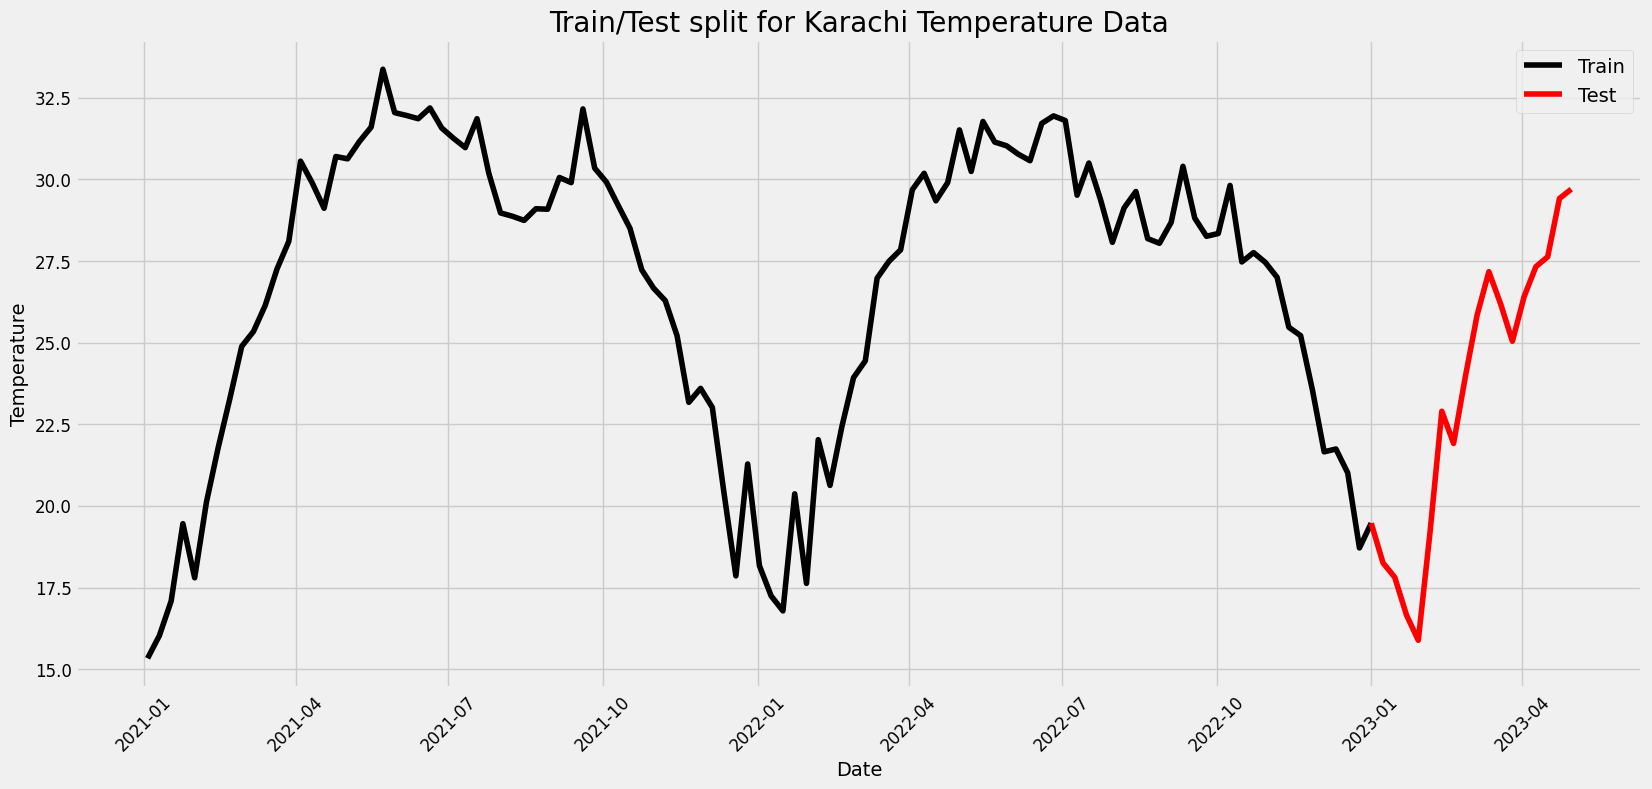

In [9]:
train = week_data[week_data.index <= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
test = week_data[week_data.index >= pd.to_datetime("2023-01-01", format='%Y-%m-%d')]
plt.plot(train, color="black", label='Train')
plt.plot(test, color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Karachi Temperature Data")
plt.legend()
plt.show()

#Q4)

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import itertools

Best RMSE 3.6834310636491687 with combination of (2, 2, 2) 



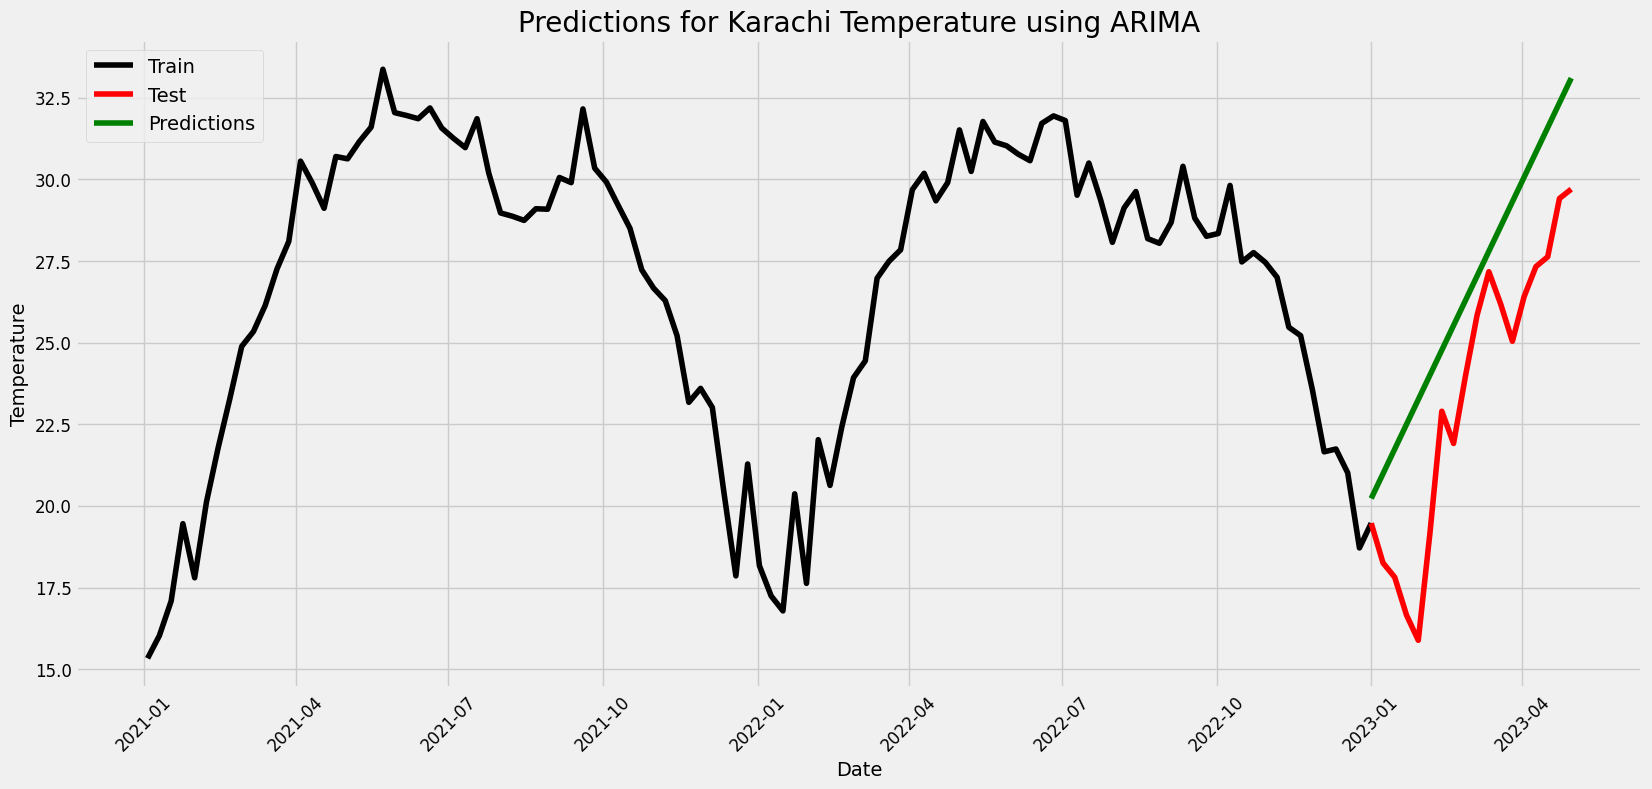

In [12]:
def bestARIMA(p, d, q):
    ArimaModel = ARIMA(train, order=(p, d, q))
    ArimaModel = ArimaModel.fit()
    y_pred = ArimaModel.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha=0.05)
    y_pred_df['Predictions'] = ArimaModel.predict(start= y_pred_df.index[0], end= y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"]
    arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_out))
    return arma_rmse, y_pred_out

RMSE = float('inf')
n = [0, 1, 2]
combinations = list(itertools.product(n, repeat=3))
for i in combinations:
    result = bestARIMA(i[0], i[1], i[2])
    if result[0] < RMSE:
        RMSE = result[0]
        y_pred_out = result[1]

print(f'Best RMSE {RMSE} with combination of {i} \n')
plt.plot(train, color="black", label='Train')
plt.plot(test, color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions for Karachi Temperature using ARIMA")
plt.plot(y_pred_out, color='green', label='Predictions')
plt.legend()
plt.show()


#Q5)

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Best RMSE 2.3069647225139405 with order = (1, 1, 1) and seasonalOrder = (1, 1, 1, 52) 



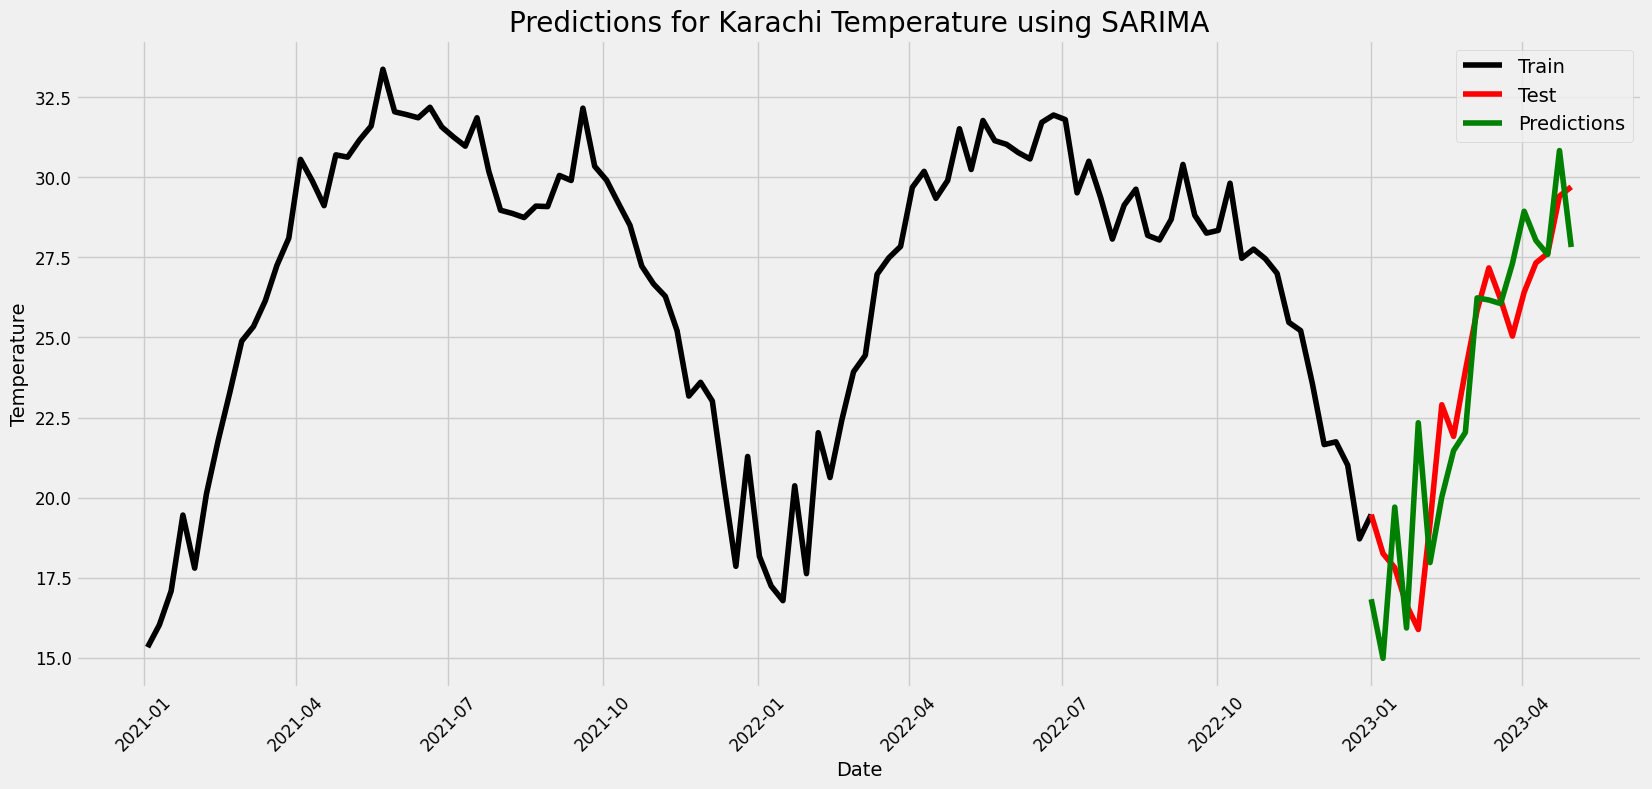

In [17]:
def bestSARIMA(orderList, seasonalOrder):
    SARIMAXmodel = SARIMAX(train, order = orderList, seasonal_order = seasonalOrder)
    SARIMAXmodel = SARIMAXmodel.fit()
    y_pred = SARIMAXmodel.get_forecast(len(test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05)
    y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
    y_pred_df.index = test.index
    y_pred_out = y_pred_df["Predictions"]
    arma_rmse = np.sqrt(mean_squared_error(test.values, y_pred_out))
    return arma_rmse, y_pred_out

n = [0, 1]
orderList = list(itertools.product(n, repeat=3))
seasonalList = list(itertools.product(n, repeat=3))
for i in range(len(seasonalList)):
  seasonalList[i] = (seasonalList[i][0], seasonalList[i][1], seasonalList[i][2], 52)
RMSE = float('inf')
for i in range(len(orderList)):
    result = bestSARIMA(orderList[i], seasonalList[i])
    if result[0] < RMSE:
        RMSE = result[0]
        y_pred_out = result[1]
print(f'Best RMSE {RMSE} with order = {orderList[i]} and seasonalOrder = {seasonalList[i]} \n')
plt.plot(train, color="black", label='Train')
plt.plot(test, color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions for Karachi Temperature using SARIMA")
plt.plot(y_pred_out, color='green', label='Predictions')
plt.legend()
plt.show()

#Q6)

In [18]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False
                                            )
            results = mod.fit()
            print('ARIMA{}x{}52 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)52 - AIC:984.8420684895568
ARIMA(0, 0, 0)x(0, 0, 1, 52)52 - AIC:494.7744164276224
ARIMA(0, 0, 0)x(0, 1, 0, 52)52 - AIC:172.65649630216632
ARIMA(0, 0, 0)x(0, 1, 1, 52)52 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 52)52 - AIC:178.74279486497463
ARIMA(0, 0, 0)x(1, 0, 1, 52)52 - AIC:172.4348483434874
ARIMA(0, 0, 0)x(1, 1, 0, 52)52 - AIC:-16.21189096721141
ARIMA(0, 0, 0)x(1, 1, 1, 52)52 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 52)52 - AIC:849.1082414922065
ARIMA(0, 0, 1)x(0, 0, 1, 52)52 - AIC:422.94360618989003
ARIMA(0, 0, 1)x(0, 1, 0, 52)52 - AIC:171.25382044885626
ARIMA(0, 0, 1)x(0, 1, 1, 52)52 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 52)52 - AIC:180.95459329646303
ARIMA(0, 0, 1)x(1, 0, 1, 52)52 - AIC:171.05959681377476
ARIMA(0, 0, 1)x(1, 1, 0, 52)52 - AIC:-14.775303225183155
ARIMA(0, 0, 1)x(1, 1, 1, 52)52 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 52)52 - AIC:367.56405761422843
ARIMA(0, 1, 0)x(0, 0, 1, 52)52 - AIC:187.7330824803878
ARIMA(0, 1, 0)x(0, 1, 0, 52)52 - AIC:201.2580770419524
A

2.6211095865174174


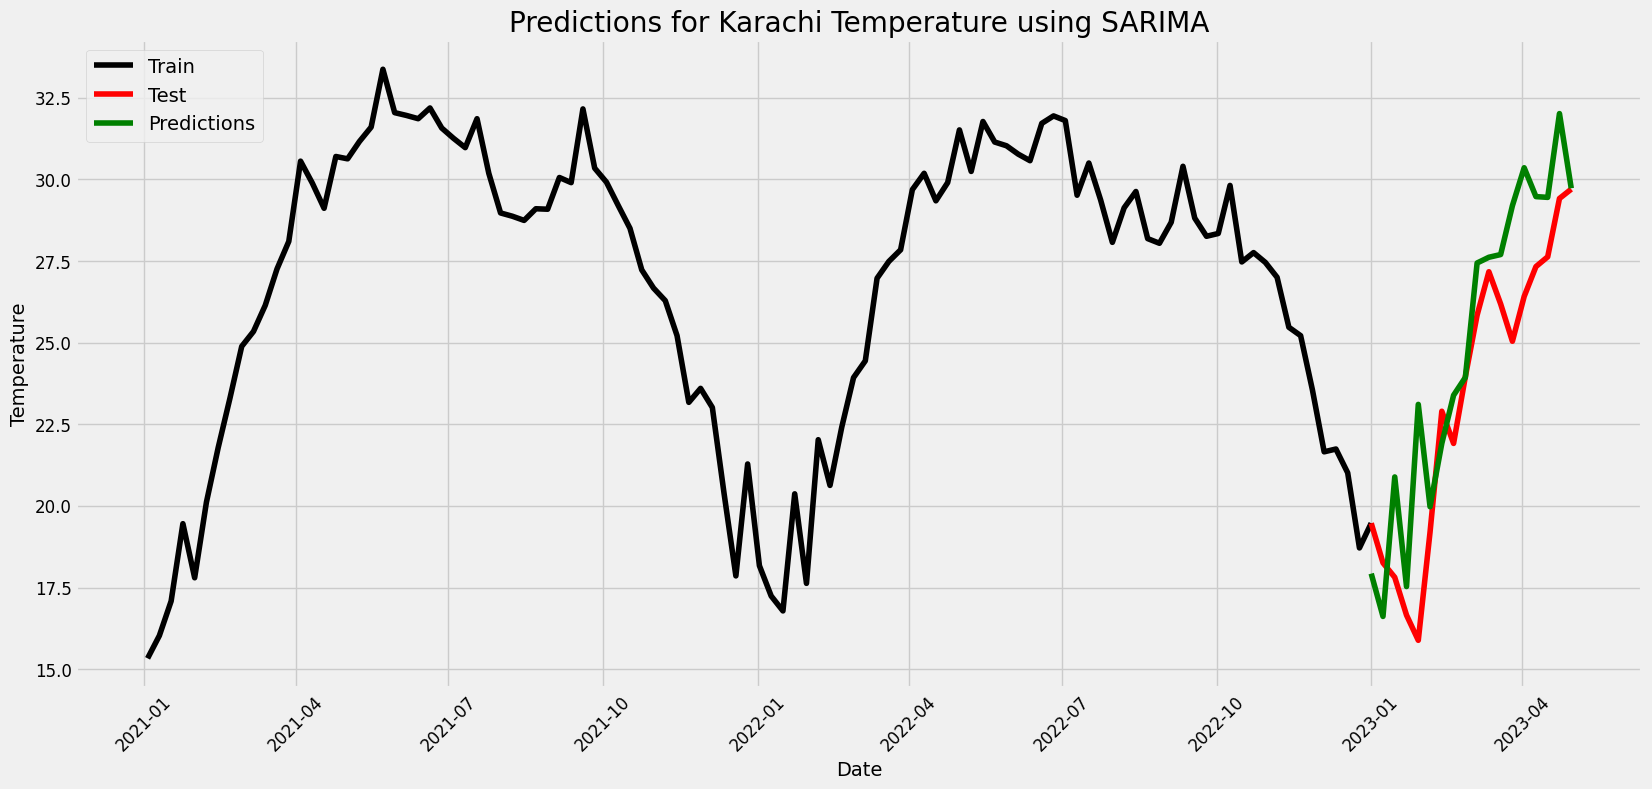

In [19]:
result = bestSARIMA((0,0,0), (1,1,0,52))
RMSE = result[0]
y_pred_out = result[1]
print(RMSE)
plt.plot(train, color="black", label='Train')
plt.plot(test, color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions for Karachi Temperature using SARIMA")
plt.plot(y_pred_out, color='green', label='Predictions')
plt.legend()
plt.show()

#Q7)

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [21]:
month = [x.month for x in train.index]
year = [x.year for x in train.index]
day = [x.day for x in train.index]
X = np.array([day, month, year]).T
Y = train.values
testMonth = [x.month for x in test.index]
testYear = [x.year for x in test.index]
testDay = [x.day for x in test.index]
testX = np.array([testDay, testMonth, testYear]).T
testY = test.values

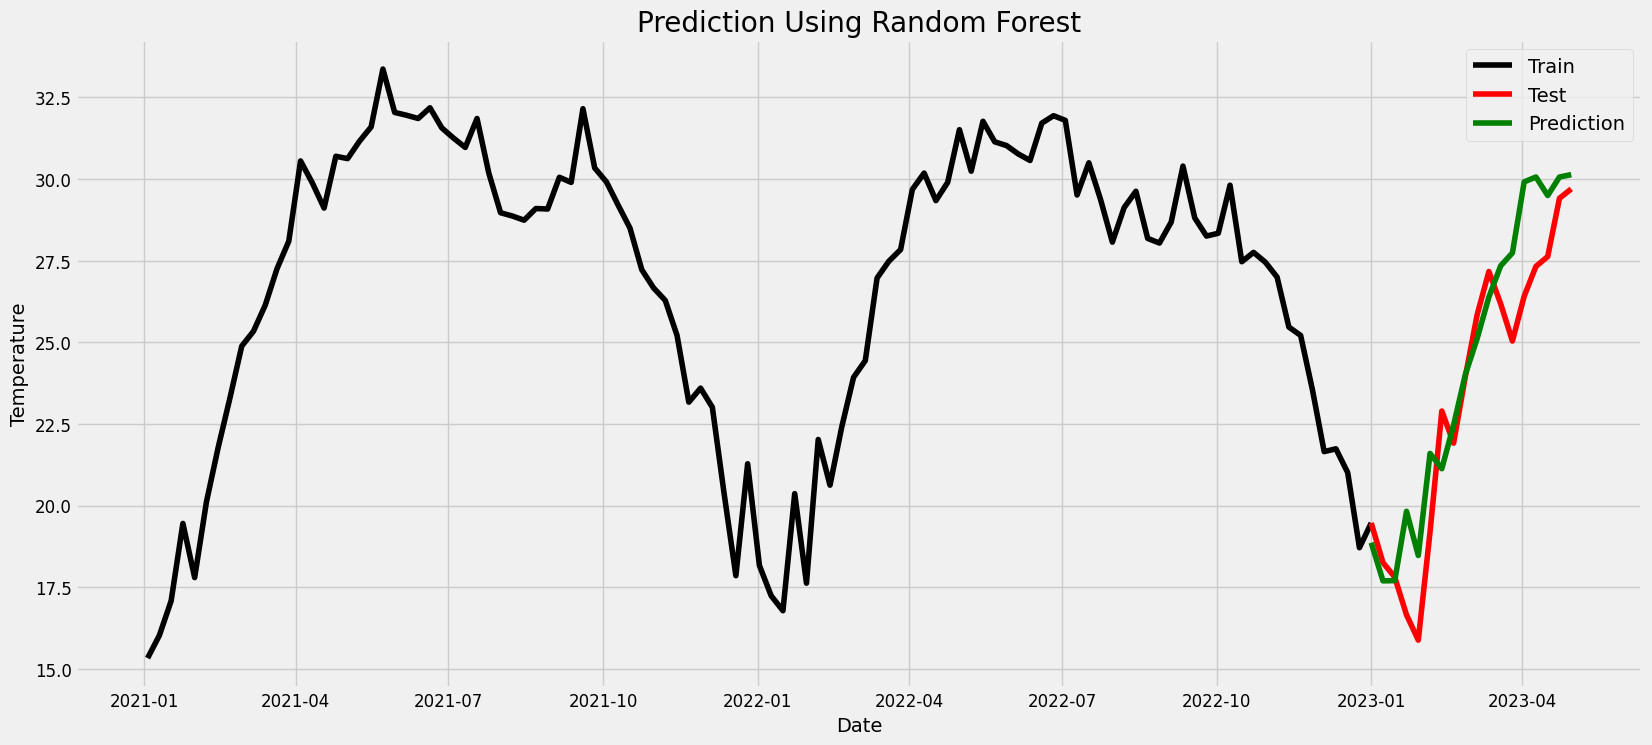

RMSE = 1.8301084136243342


In [22]:
rfmodel = RandomForestRegressor()
rfmodel.fit(X,Y)
prediction = rfmodel.predict(testX)
plt.plot(train.index, train.values,color="black", label='Train')
plt.plot(test.index, test.values,color="red", label='Test')
plt.plot(test.index, prediction, color="green",label='Prediction')
plt.legend()
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.title("Prediction Using Random Forest")
plt.show()
rmse = np.sqrt(mean_squared_error(test.values, prediction))
print(f'RMSE = {rmse}')

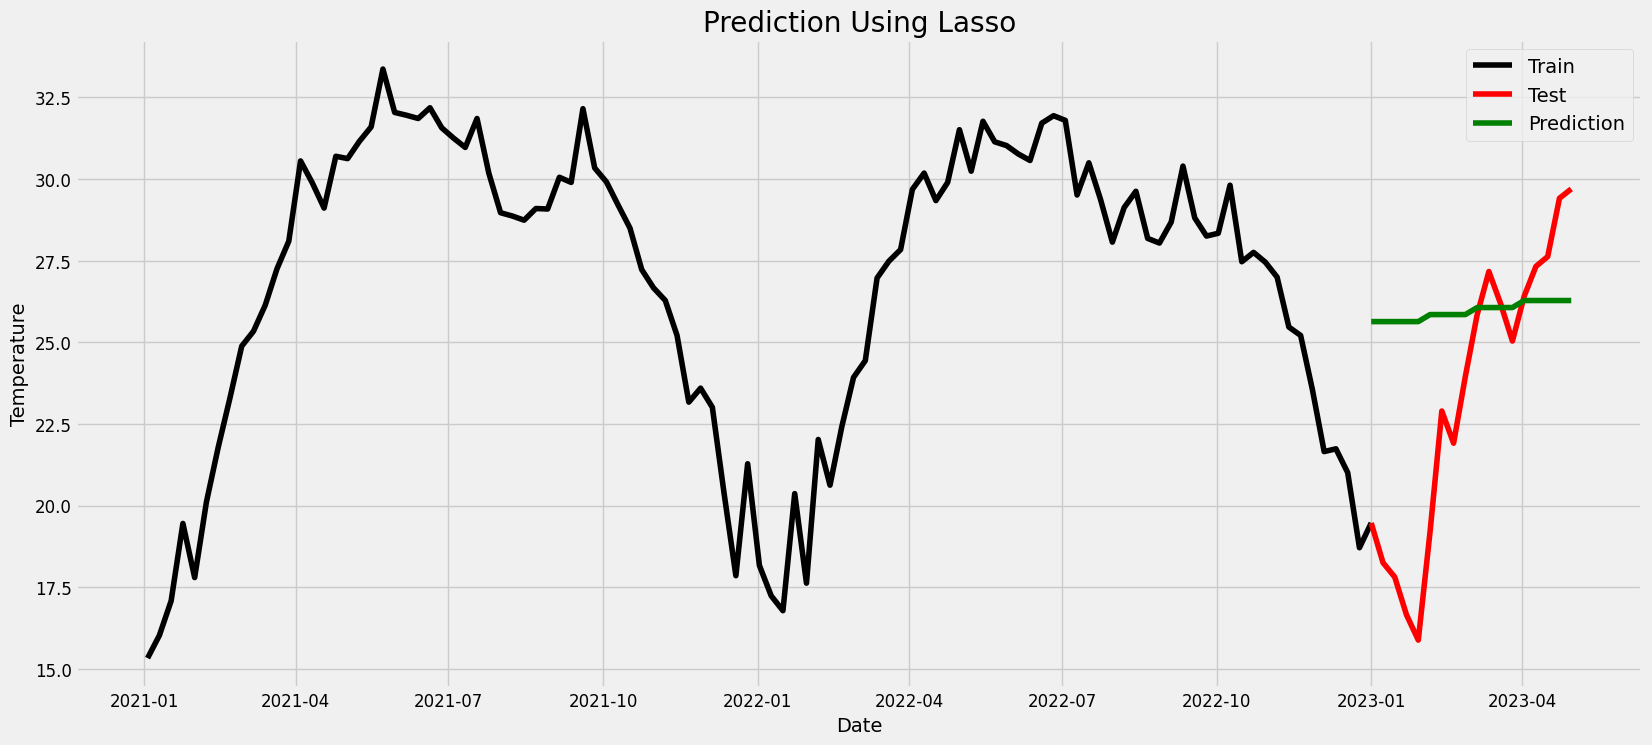

RMSE = 4.878043883878313


In [23]:
lassoModel = Lasso(alpha=1)
lassoModel.fit(X ,Y)
prediction = lassoModel.predict(testX)
plt.plot(train.index, train.values,color="black", label='Train')
plt.plot(test.index, test.values,color="red", label='Test')
plt.plot(test.index, prediction, color="green",label='Prediction')
plt.legend()
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.title("Prediction Using Lasso")
plt.show()
rmse = np.sqrt(mean_squared_error(test.values, prediction))
print(f'RMSE = {rmse}')

#Q8)

ARIMA = 3.68 <br>
SARIMAX = 2.30 <br>
Random Forest = 1.80 <br>
Lasso = 4.87 <br>

Random Forest regression seems to generate the most accurate predictions with the lowest root mean square error, according to the RMSE analysis. While SARIMA is a good model to capture seasonality and time-dependent relationships, other machine learning models that can capture non-linear relationships between the target variable and features are Random Forest Regression and Lasso Regression. Despite the data's similarity, Random Forest Regression performs marginally better by 0.09 units, so SARIMA might not always yield the best results. However, the input values determine how effective these models are, and optimizing the parameters—such as determining the ideal p, q, and d values for ARIMA or modifying the alpha value for Lasso Regression—can be challenging. Nonetheless, Random Forest Prediction is an ensemble learning method that combines multiple decision trees to make predictions, and it achieved the lowest RMSE, making it the best prediction model out of the rest.

#Q9)

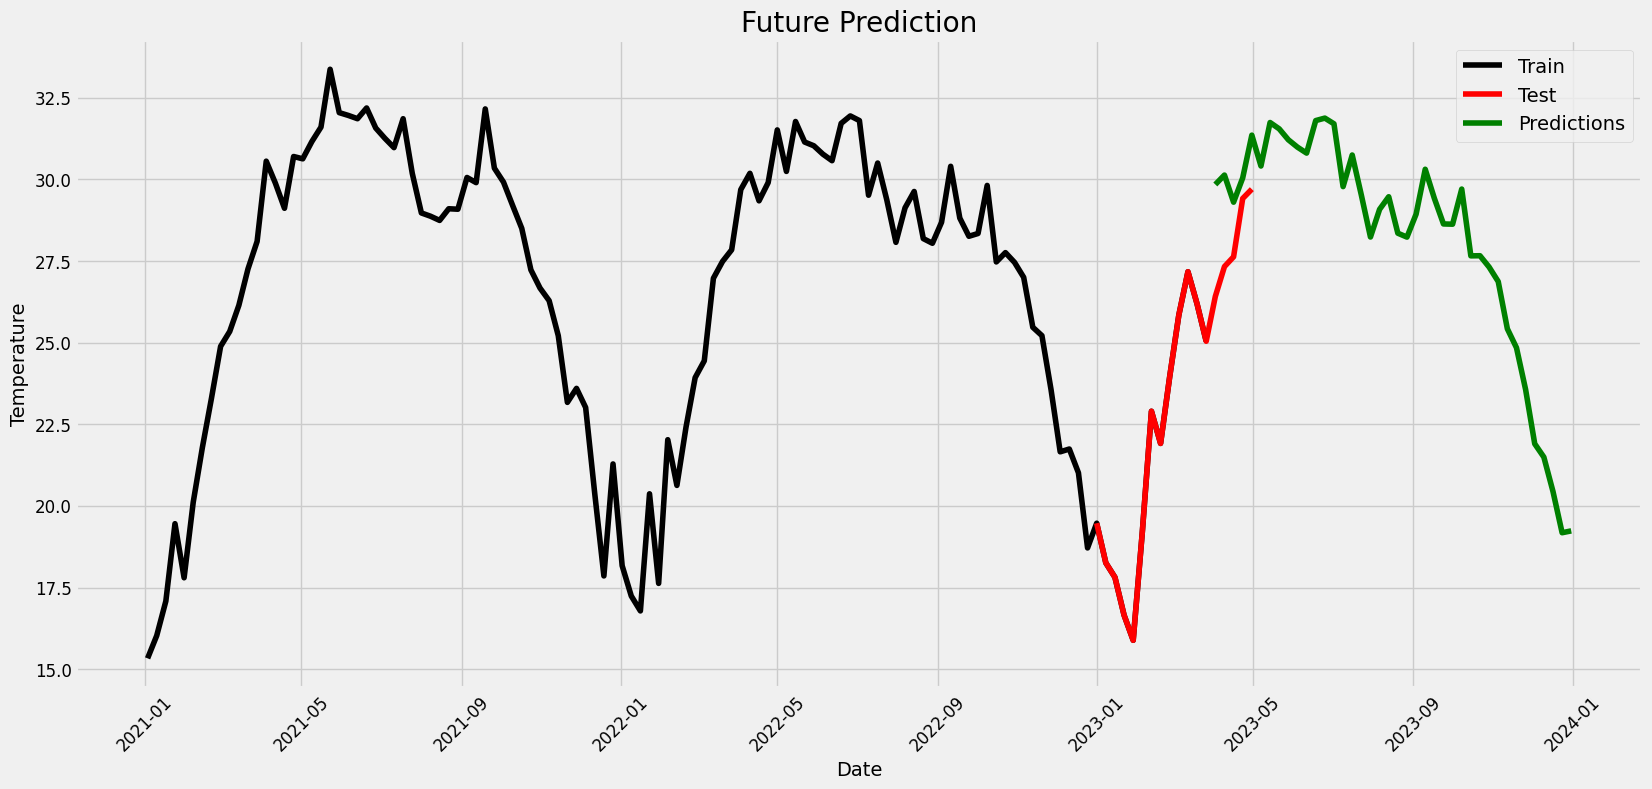

In [25]:
future = pd.date_range(start='04/01/2023', end='12/31/2023', freq='W')
train = week_data[week_data.index < pd.to_datetime("2023-04-01", format='%Y-%m-%d')]
SARIMAXmodel = SARIMAX(train, order=(0, 0, 0), seasonal_order=(1, 1, 0, 52))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(steps = len(future))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df["Predictions"] = y_pred.predicted_mean
# y_pred_df["Predictions"]

plt.plot(train, color="black", label='Train')
plt.plot(test, color="red", label='Test')
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Future Prediction")
plt.plot(y_pred_df['Predictions'], color='green', label='Predictions')
plt.legend()
plt.show()

#Q10

In [26]:
month = [x.month for x in train.index]
year = [x.year for x in train.index]
day = [x.day for x in train.index]
X = np.array([day, month, year]).T
Y = train.values

future_df = pd.DataFrame(index = future)

testMonth = [x.month for x in future_df.index]
testYear = [x.year for x in future_df.index]
testDay = [x.day for x in future_df.index]

testX = np.array([testDay, testMonth, testYear]).T
testY = future_df.values

rfmodel = RandomForestRegressor()
rfmodel.fit(X,Y)
prediction = rfmodel.predict(testX)
future_df["Prediction"] = prediction
future_df

,Prediction
2023-04-02,29.867429
2023-04-09,30.053000
2023-04-16,29.572714
2023-04-23,30.063429
2023-04-30,30.193286
2023-05-07,30.683571
2023-05-14,31.538286
2023-05-21,31.518286
2023-05-28,31.310143
2023-06-04,31.088429


#Q11)

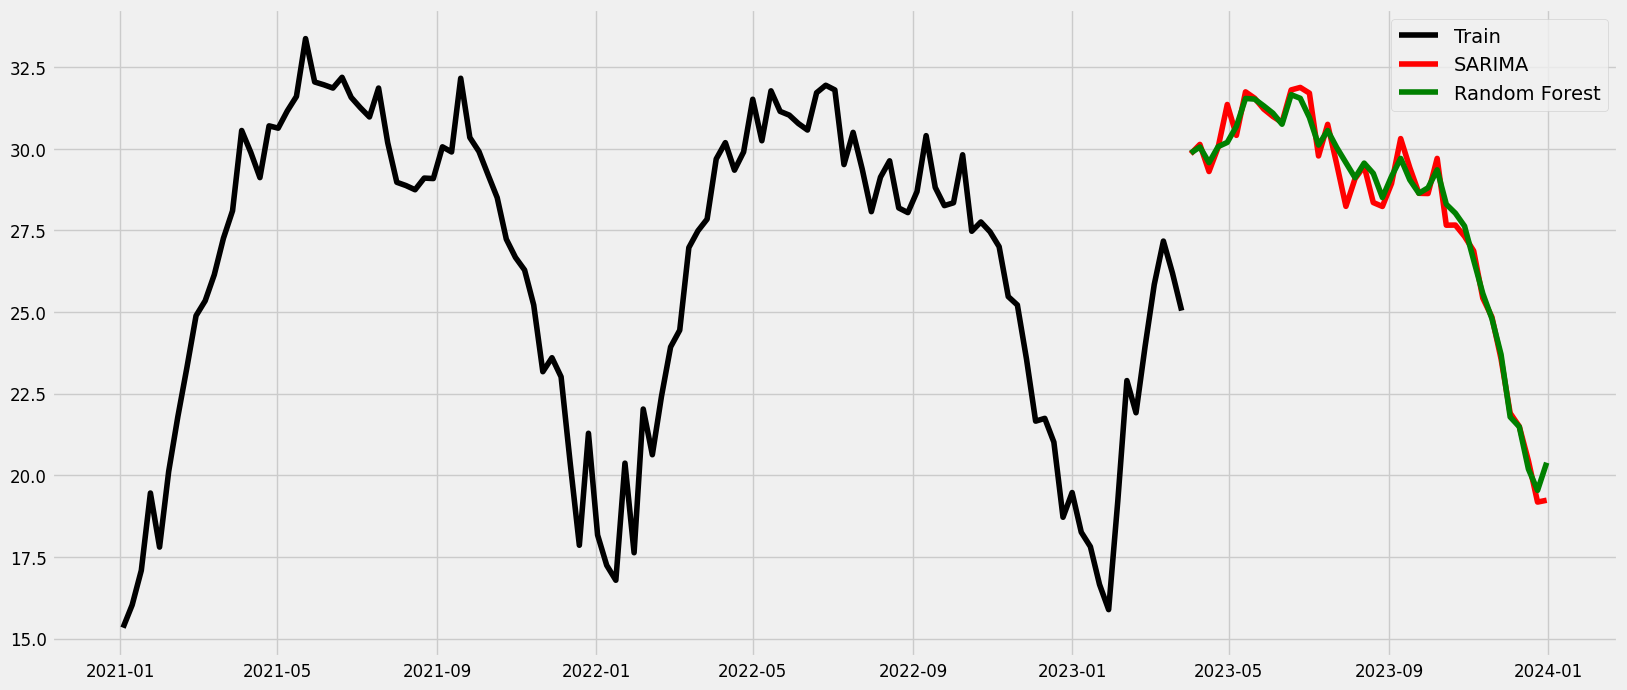

In [27]:
plt.plot(train.index, train.values,color="black", label='Train')
plt.plot(y_pred_df.index, y_pred_df["Predictions"],color="red", label='SARIMA')
plt.plot(future_df.index, prediction, color="green",label='Random Forest')
plt.legend()
plt.show()

##Analysis
From the diagram we can see that both model almost does the same job in predicting the future temperatures. Both follow a similar trend and almost has overlapping values.